Episode:   0 | Score:  18 | Epsilon: 1.000
Episode:   1 | Score:  17 | Epsilon: 1.000
Episode:   2 | Score:  18 | Epsilon: 1.000
Episode:   3 | Score:  19 | Epsilon: 0.956
Episode:   4 | Score:  19 | Epsilon: 0.869
Episode:   5 | Score:  26 | Epsilon: 0.763
Episode:   6 | Score:  12 | Epsilon: 0.718
Episode:   7 | Score:  17 | Epsilon: 0.660
Episode:   8 | Score:  10 | Epsilon: 0.627
Episode:   9 | Score:  18 | Epsilon: 0.573
Episode:  10 | Score:  27 | Epsilon: 0.501
Episode:  11 | Score:  14 | Epsilon: 0.467
Episode:  12 | Score:  12 | Epsilon: 0.440
Episode:  13 | Score:  17 | Epsilon: 0.404
Episode:  14 | Score:  27 | Epsilon: 0.353
Episode:  15 | Score:  12 | Epsilon: 0.332
Episode:  16 | Score:  16 | Epsilon: 0.306
Episode:  17 | Score:  15 | Epsilon: 0.284
Episode:  18 | Score:  10 | Epsilon: 0.270
Episode:  19 | Score:  14 | Epsilon: 0.252
Episode:  20 | Score:  33 | Epsilon: 0.214
Episode:  21 | Score:  27 | Epsilon: 0.187
Episode:  22 | Score:  21 | Epsilon: 0.168
Episode:  2

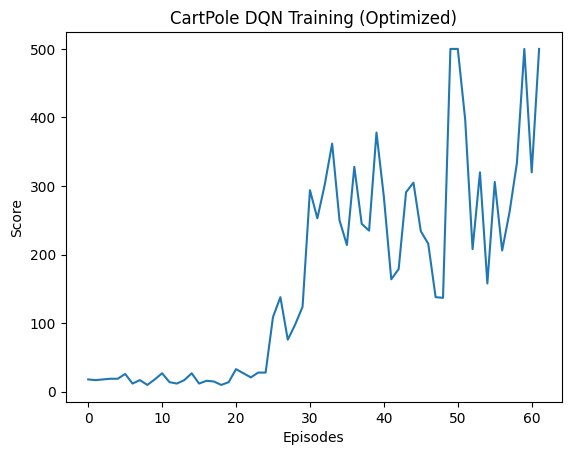

In [2]:
import random
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Disable TensorFlow logs for cleaner output
tf.get_logger().setLevel('ERROR')

EPISODES = 100

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=5000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 64
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Input(shape=(self.state_size,)),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def save(self, filename):
        # Keras 3 requires .weights.h5 extension for save_weights
        if not filename.endswith(".weights.h5"):
            filename += ".weights.h5"
        self.model.save_weights(filename)

    def load(self, filename):
        if not filename.endswith(".weights.h5"):
            filename += ".weights.h5"
        self.model.load_weights(filename)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)

        states = np.zeros((self.batch_size, self.state_size))
        next_states = np.zeros((self.batch_size, self.state_size))
        actions, rewards, dones = [], [], []

        for i, (s, a, r, s2, d) in enumerate(minibatch):
            states[i] = s
            next_states[i] = s2
            actions.append(a)
            rewards.append(r)
            dones.append(d)

        # Batch predictions (fast)
        target = self.model.predict(states, verbose=0)
        target_next = self.model.predict(next_states, verbose=0)

        for i in range(self.batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.gamma * np.max(target_next[i])

        self.model.fit(states, target, batch_size=self.batch_size, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


# ---------------- MAIN ---------------- #
if __name__ == "__main__":
    env = gym.make("CartPole-v1")
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)

    scores = []
    episodes = []

    for e in range(EPISODES):
        state, _ = env.reset()
        state = np.reshape(state, [1, state_size])
        done = False
        t = 0

        while not done:
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            reward = reward if not done else -10
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            t += 1

            agent.replay()  # train every step

        print(f"Episode: {e:3d} | Score: {t:3d} | Epsilon: {agent.epsilon:.3f}")
        scores.append(t)
        episodes.append(e)

        # Early stopping if solved
        if np.mean(scores[-50:]) >= 195:
            print(f"Solved in {e} episodes.")
            break

    agent.save("cartpole_dqn_fast.weights.h5")

    plt.plot(episodes, scores)
    plt.xlabel("Episodes")
    plt.ylabel("Score")
    plt.title("CartPole DQN Training (Optimized)")
    plt.show()